# 📰 Fake News Detection Dataset

This notebook uses the [Fake News Detection dataset](https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection) from Kaggle, which contains labeled news articles for building and evaluating fake news classifiers.

# 📦 Import Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ML & NLP Libraries

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2

ML Models and Evaluation

In [36]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score


# Load Dataset

In [37]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")
print(f"Fake.csv shape: {fake_df.shape[0]} rows, {fake_df.shape[1]} columns")
print(f"True.csv shape: {true_df.shape[0]} rows, {true_df.shape[1]} columns")

Fake.csv shape: 23481 rows, 4 columns
True.csv shape: 21417 rows, 4 columns


In [38]:
print('Fake News DataFrame:')
print(fake_df.head())
fake_df.info()

print('\nTrue News DataFrame:')
print(true_df.head())
true_df.info()
# Combine the datasets


Fake News DataFrame:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column

Add labels

In [39]:
fake_df['label'] = 0  # Fake
true_df['label'] = 1  # True

# Data Pre-processing

Combine Dataset

In [40]:
df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)
print(f"Combined dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Combined dataset shape: 44898 rows, 5 columns


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


Handle Missing Values

In [41]:
# Drop nulls if any
df.dropna(inplace=True)

# Combine title + text (optional)
df['content'] = df['title'] + " " + df['text']
df['content'] = df['content'].str.lower().str.replace(r"[^a-zA-Z\s]", "", regex=True)

In [42]:
print("Missing values in each column:")
print(df.isnull().sum())
print("\nPercentage of missing values in each column:")
print((df.isnull().mean() * 100).round(2))

Missing values in each column:
title      0
text       0
subject    0
date       0
label      0
content    0
dtype: int64

Percentage of missing values in each column:
title      0.0
text       0.0
subject    0.0
date       0.0
label      0.0
content    0.0
dtype: float64


Fix Outliers

In [43]:
min_length = 10
initial_count = len(df)
df = df[df['content'].str.len() >= min_length]
print(f"Removed {initial_count - len(df)} rows with empty or very short content (less than {min_length} characters).")

max_length = df['content'].str.len().quantile(0.99)
df['content'] = df['content'].apply(lambda x: x[:int(max_length)])
print(f"Capped article length at {int(max_length)} characters (99th percentile).")

Removed 0 rows with empty or very short content (less than 10 characters).
Capped article length at 9044 characters (99th percentile).


# Features & Labels

In [44]:
X = df['content']
y = df['label']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

🔹 Feature Selection

In [45]:
# Vectorize text data
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print(f"X_train_vec shape: {X_train_vec.shape}")
print(f"X_test_vec shape: {X_test_vec.shape}")

X_train_vec shape: (35918, 10000)
X_test_vec shape: (8980, 10000)


In [46]:
selector = SelectKBest(chi2, k=5000)
X_train_sel = selector.fit_transform(X_train_vec, y_train)
X_test_sel = selector.transform(X_test_vec)

## 🔗 Feature Correlation Analysis

Understanding the correlation between features can help identify redundant or highly related variables, which may impact model performance. The following heatmap visualizes the correlation matrix for the top selected features in the dataset.

**Note:**

Correlation analysis requires numeric features. The original columns (`title`, `text`, `subject`, `date`) are mostly text or categorical data, which cannot be directly used for correlation calculations. Therefore, we first convert the text data into numeric features using TF-IDF vectorization and feature selection. The correlation heatmap below is computed on these selected numeric features, representing the most important words or tokens from the text. This approach allows us to analyze relationships and redundancy among the features that the model actually uses.

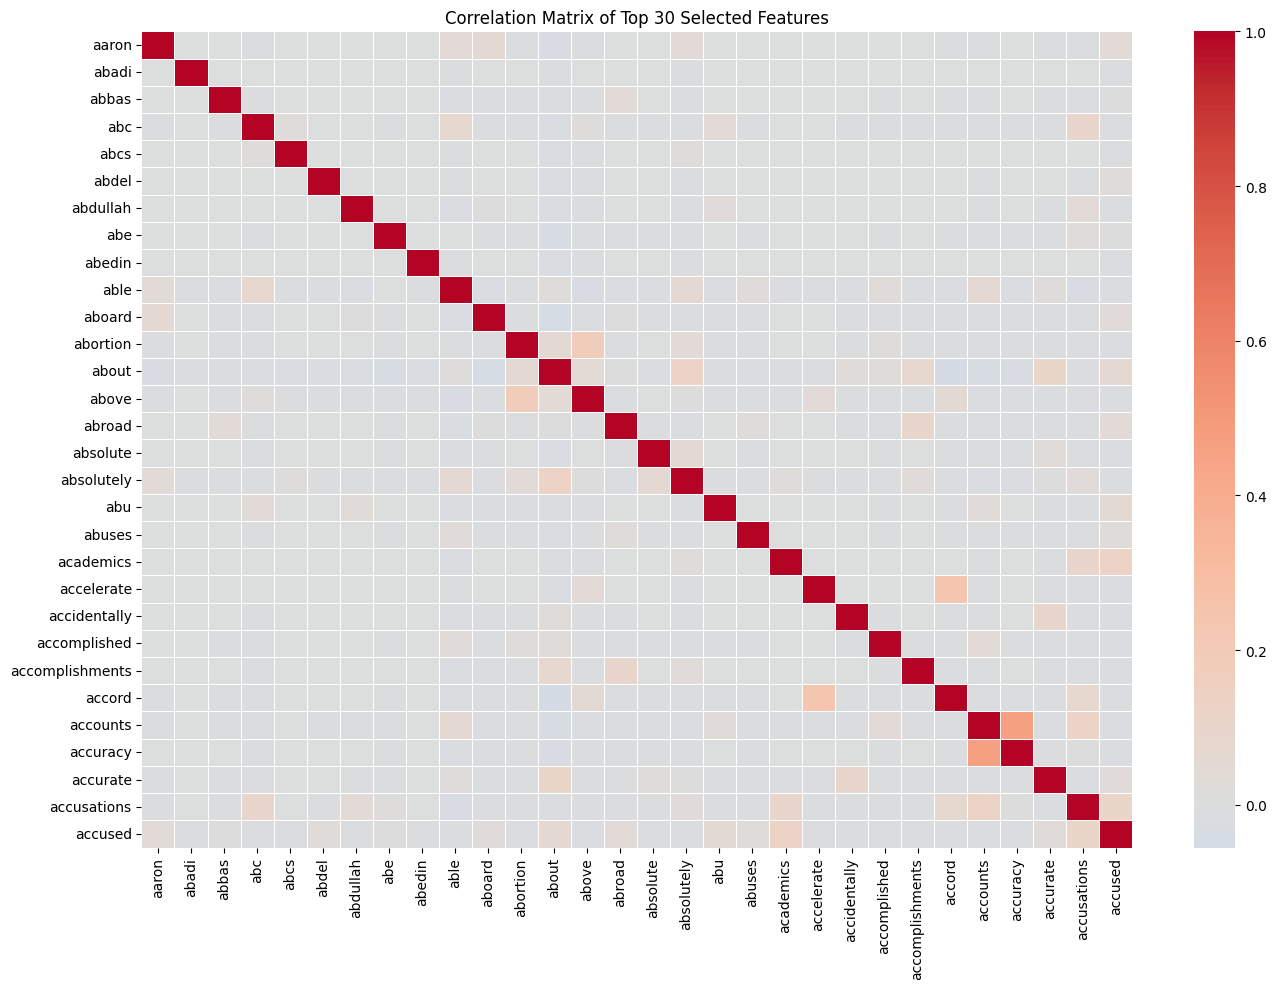

'\nThis heatmap shows the pairwise correlation between the most important features selected from the text data.\nHigh correlation (close to 1 or -1) may indicate redundancy, while low correlation suggests diverse information.\n'

In [47]:
# Visualize correlation between top features
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 30 selected feature names
feature_names = np.array(vectorizer.get_feature_names_out())[selector.get_support(indices=True)][:30]

# Convert the selected features to a dense DataFrame (sample for visualization)
X_sample = X_train_sel[:1000, :30].toarray()  # Use a sample for speed
corr_df = pd.DataFrame(X_sample, columns=feature_names)

# Compute the correlation matrix
corr_matrix = corr_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Top 30 Selected Features')
plt.tight_layout()
plt.show()

"""
This heatmap shows the pairwise correlation between the most important features selected from the text data.
High correlation (close to 1 or -1) may indicate redundancy, while low correlation suggests diverse information.
"""

🔹 Normalization

In [48]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

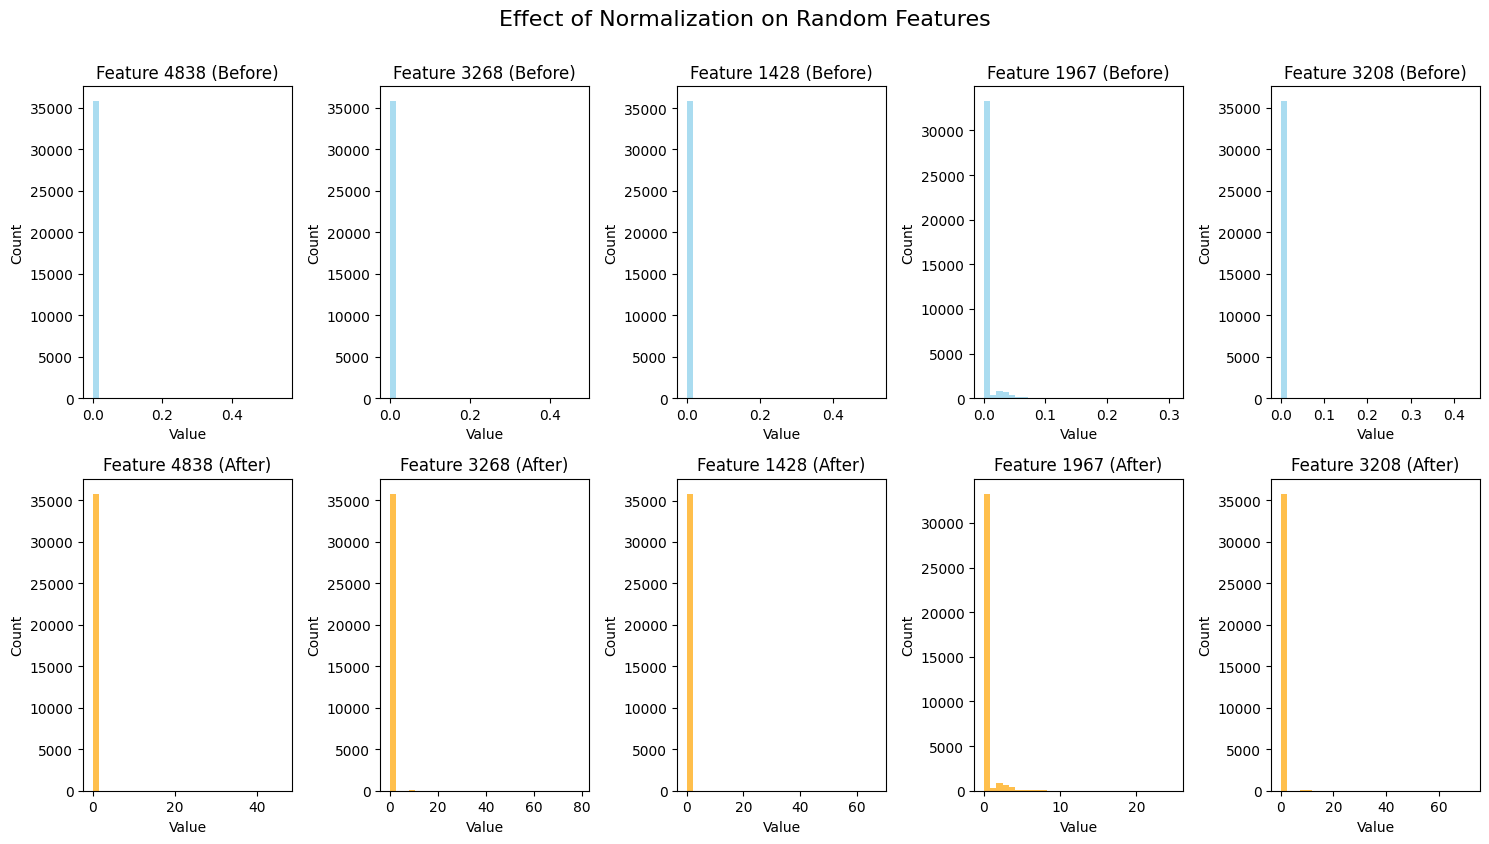

In [49]:
# Visualize normalization effect on feature distributions
import random

# Select a random sample of features to plot
num_features = 5
feature_indices = random.sample(range(X_train_sel.shape[1]), num_features)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(feature_indices):
    plt.subplot(2, num_features, i+1)
    plt.hist(X_train_sel[:, idx].toarray().flatten(), bins=30, color='skyblue', alpha=0.7)
    plt.title(f'Feature {idx} (Before)')
    plt.xlabel('Value')
    plt.ylabel('Count')
    
    plt.subplot(2, num_features, num_features+i+1)
    plt.hist(X_train_scaled[:, idx].toarray().flatten(), bins=30, color='orange', alpha=0.7)
    plt.title(f'Feature {idx} (After)')
    plt.xlabel('Value')
    plt.ylabel('Count')

plt.tight_layout()
plt.suptitle('Effect of Normalization on Random Features', y=1.05, fontsize=16)
plt.show()

Model Setup

In [50]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

results = {}

## Model Training & Evaluation

Check Model-Fit with Accuracy

In [51]:
# Loop through models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Accuracy metrics
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n📌 {name}")
    print("Training Accuracy:", round(train_acc, 4))
    print("Testing Accuracy :", round(test_acc, 4))
    print("Precision         :", round(pre, 4))
    print("Recall            :", round(rec, 4))
    print("F1 Score          :", round(f1, 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Save results
    results[name] = [acc, pre, rec, f1]

    # Overfit/Underfit Check
    print("🔍 Fit Check:", end=" ")
    if train_acc > 0.95 and (train_acc - test_acc) > 0.10:
        print("⚠️ Overfitting detected.")
    elif train_acc < 0.75 and test_acc < 0.75:
        print("⚠️ Underfitting detected.")
    else:
        print("✅ Model is well-fitted.")



📌 Random Forest
Training Accuracy: 1.0
Testing Accuracy : 0.998
Precision         : 0.9977
Recall            : 0.9981
F1 Score          : 0.9979
Confusion Matrix:
 [[4686   10]
 [   8 4276]]
🔍 Fit Check: ✅ Model is well-fitted.

📌 Logistic Regression
Training Accuracy: 1.0
Testing Accuracy : 0.9961
Precision         : 0.9972
Recall            : 0.9946
F1 Score          : 0.9959
Confusion Matrix:
 [[4684   12]
 [  23 4261]]
🔍 Fit Check: ✅ Model is well-fitted.

📌 KNN
Training Accuracy: 0.698
Testing Accuracy : 0.6644
Precision         : 0.9575
Recall            : 0.3102
F1 Score          : 0.4686
Confusion Matrix:
 [[4637   59]
 [2955 1329]]
🔍 Fit Check: ⚠️ Underfitting detected.

📌 Decision Tree
Training Accuracy: 1.0
Testing Accuracy : 0.9954
Precision         : 0.9963
Recall            : 0.9942
F1 Score          : 0.9952
Confusion Matrix:
 [[4680   16]
 [  25 4259]]
🔍 Fit Check: ✅ Model is well-fitted.


In [52]:
# Classification Report: KNN
from sklearn.metrics import classification_report
knn_pred = models["KNN"].predict(X_test_scaled)
print(classification_report(y_test, knn_pred, target_names=["Fake", "True"]))

              precision    recall  f1-score   support

        Fake       0.61      0.99      0.75      4696
        True       0.96      0.31      0.47      4284

    accuracy                           0.66      8980
   macro avg       0.78      0.65      0.61      8980
weighted avg       0.78      0.66      0.62      8980



In [53]:
# Classification Report: Logistic Regression
from sklearn.metrics import classification_report
lr_pred = models["Logistic Regression"].predict(X_test_scaled)
print(classification_report(y_test, lr_pred, target_names=["Fake", "True"]))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        True       1.00      0.99      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [54]:
# Classification Report: Decision Tree
from sklearn.metrics import classification_report
dt_pred = models["Decision Tree"].predict(X_test_scaled)
print(classification_report(y_test, dt_pred, target_names=["Fake", "True"]))

              precision    recall  f1-score   support

        Fake       0.99      1.00      1.00      4696
        True       1.00      0.99      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [55]:
# Classification Report: Random Forest
from sklearn.metrics import classification_report
rf_pred = models["Random Forest"].predict(X_test_scaled)
print(classification_report(y_test, rf_pred, target_names=["Fake", "True"]))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        True       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



## 📊 Demonstrating the Benefits of Ensemble Models

The following example uses the breast cancer dataset to compare the performance of individual classifiers (Decision Tree, Logistic Regression, KNN) with an ensemble model (Random Forest). This demonstrates how ensemble methods can improve accuracy and stability over single models, using 10-fold cross-validation for a robust comparison.

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already defined:
# X = your feature matrix from TF-IDF or CountVectorizer
# y = your labels (e.g., df['label'])

# List of base models and the ensemble model
models = [
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Ensemble (Random Forest)', RandomForestClassifier(n_estimators=100, random_state=42))
]

# Compare performance using 10-fold cross-validation
plt.figure(figsize=(12, 6))
box_data = []
names = []

print("Comparing individual models with ensemble model (Random Forest):\n")
for name, model in models:
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    box_data.append(scores)
    names.append(name)
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}, Std Dev = {scores.std():.4f}")

# Plotting the boxplot
plt.boxplot(box_data, labels=names, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'))

plt.title('Comparison of Model Performance (10-fold CV)', fontsize=15)
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

for i, data in enumerate(box_data, 1):
    plt.text(i, min(data)-0.01, f"Mean: {np.mean(data):.4f}", 
             horizontalalignment='center', size='small', color='darkblue', weight='semibold')

plt.tight_layout()
plt.show()


Comparing individual models with ensemble model (Random Forest):



ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\tree\_classes.py", line 1024, in fit
    super()._fit(
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\tree\_classes.py", line 252, in _fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 2966, in validate_data
    X = check_array(X, input_name="X", **check_X_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\series.py", line 1033, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: ' dem ags respond to trump rolling back clean water rule see you in court amateur president donald trump s hostility towards the environmental protection agency is revealing by his pick to head the epa who attacked his own agency during an address to the conservative political action summit last week the former reality show star is hell bent on raping the environment this time with an executive order directing the environmental protection agency and the army corps of engineers to consider rolling back a regulation aimed at protecting america s waterways from pollutionapparently the alleged president doesn t realize that humans need water to live there s a price to pay for such action such as lawsuits and that s something trump is familiar with but he s about to get a ton of sht coming down on him via democratic attorney generals for rolling back that protection on clean watertalking points memo reports we strongly oppose president trump s action today that undermines clean water act protections and the public health and environment of our states  the attorneys general in new york hawaii massachusetts oregon vermont and the district of columbia said in a statementthe group of attorneys general led by new york attorney general eric schneiderman suggested taking legal action against the trump administration in the statement we won t hesitate to protect our people and our environment including by aggressively opposing in court president trump s actions that ignore both the law and the public s paramount need for clean water  the ags wrote abandoning the clean water rule will allow uncontrolled pollution of these critical water resources it could also harm the competitiveness of our state economies by forcing us to spend more to clean up the pollution of deregulated waters coming from upstream states that refuse to control such pollution  they added in the statementas for scott pruitt trump s pick as environmental protection agency administrator it was recently revealed that he used a private email to conduct state business while he was attorney general in oklahoma and lied about it under oath trump picked a man to head the epa who previously   wait for it   sued the epa  timestrump and pruitt are dangerous for our environmentphoto by mario tamagetty images'

--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\tree\_classes.py", line 1024, in fit
    super()._fit(
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\tree\_classes.py", line 252, in _fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 2966, in validate_data
    X = check_array(X, input_name="X", **check_X_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SAJIB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\series.py", line 1033, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: ' donald trump sends out embarrassing new years eve message this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to his enemies haters and  the very dishonest fake news media  the former reality show star had just one job to do and he couldn t do it as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year  president angry pants tweeted   will be a great year for america as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year  will be a great year for america  donald j trump realdonaldtrump december  trump s tweet went down about as welll as you d expectwhat kind of president sends a new year s greeting like this despicable petty infantile gibberish only trump his lack of decency won t even allow him to rise above the gutter long enough to wish the american citizens a happy new year  bishop talbert swan talbertswan december  no one likes you  calvin calvinstowell december  your impeachment would make  a great year for america but i ll also accept regaining control of congress  miranda yaver mirandayaver december  do you hear yourself talk when you have to include that many people that hate you you have to wonder why do the they all hate me  alan sandoval alansandoval december  who uses the word haters in a new years wish  marlene marlene december  you can t just say happy new year  koren pollitt korencarpenter december  here s trump s new year s eve tweet from happy new year to all including to my many enemies and those who have fought me and lost so badly they just don t know what to do love  donald j trump realdonaldtrump december  this is nothing new for trump he s been doing this for yearstrump has directed messages to his  enemies  and  haters  for new year s easter thanksgiving and the anniversary of  pictwittercomfpaekypa  daniel dale ddale december  trump s holiday tweets are clearly not presidentialhow long did he work at hallmark before becoming president  steven goodine sgoodine december  he s always been like this    the only difference is that in the last few years his filter has been breaking down  roy schulze thbthttt december  who apart from a teenager uses the term haters  wendy wendywhistles december  he s a fucking  year old  who knows rainyday december  so to all the people who voted for this a hole thinking he would change once he got into power you were wrong yearold men don t change and now he s a year olderphoto by andrew burtongetty images'


<Figure size 1200x600 with 0 Axes>

 🔹 Ensemble: Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Define all models in a dictionary
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

# Train individual models
for model in models.values():
    model.fit(X_train_scaled, y_train)

# Create VotingClassifier (you can include or exclude any models)
voting_model = VotingClassifier(
    estimators=[
        ('rf', models["Random Forest"]),
        ('lr', models["Logistic Regression"]),
        ('dt', models["Decision Tree"]),
        ('knn', models["KNN"])  # Added KNN to the ensemble
    ],
    voting='hard'
)
voting_model.fit(X_train_scaled, y_train)

# Predict with ensemble
y_vote = voting_model.predict(X_test_scaled)

# Collect model names from ensemble
model_names = []
for name, model in voting_model.estimators:
    if isinstance(model, RandomForestClassifier):
        model_names.append("Random Forest")
    elif isinstance(model, LogisticRegression):
        model_names.append("Logistic Regression")
    elif isinstance(model, KNeighborsClassifier):
        model_names.append("KNN")
    elif isinstance(model, DecisionTreeClassifier):
        model_names.append("Decision Tree")
    else:
        model_names.append(name)

# Evaluate all individual models to find the best
best_model = None
best_f1 = -1
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_model = name

# Final report
print(f"\n📌 Ensemble Voting Classifier (Models: {', '.join(model_names)})")
print("Accuracy:", accuracy_score(y_test, y_vote))
print("F1 Score:", f1_score(y_test, y_vote, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_vote))
print(f"\n🏆 Best Individual Model: {best_model} (F1 Score: {best_f1:.4f})")



📌 Ensemble Voting Classifier (Models: Random Forest, Logistic Regression, Decision Tree, KNN)
Accuracy: 0.9948775055679288
F1 Score: 0.9946034725480994
Confusion Matrix:
 [[4695    1]
 [  45 4239]]

🏆 Best Individual Model: Random Forest (F1 Score: 0.9984)


# Hyperparameter tuning for Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Example: Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:")
print(grid_rf.best_params_)
print("Best score on validation set:")
print(grid_rf.best_score_)

# Test the best model
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Classification report (Random Forest):")
print(classification_report(y_test, y_pred_rf))


Best parameters for Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score on validation set:
1.0
Classification report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00       104

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



Visualization:

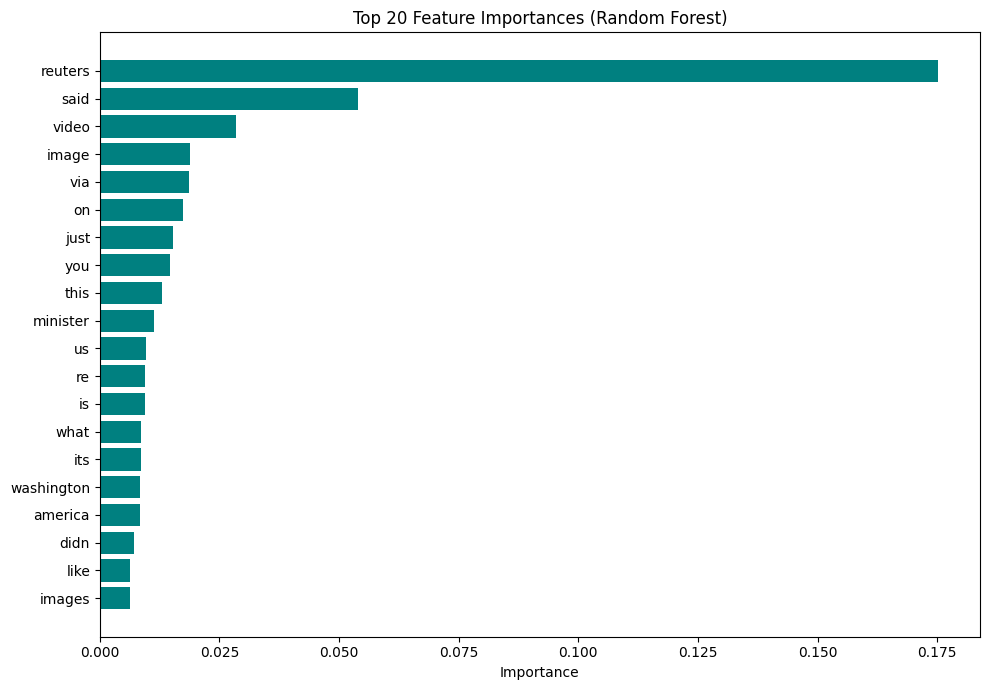

In [ ]:
# Feature Importances: Random Forest
"""
This visualization helps you understand which words have the most influence on the model’s predictions.

- By plotting the top 20 feature importances, you can see which terms are most strongly associated with fake or true news in your dataset.
- This is valuable for model interpretability, feature analysis, and explaining the model’s decisions to others.
"""
if hasattr(models["Random Forest"], "feature_importances_"):
    importances = models["Random Forest"].feature_importances_
    # Get top 20 features
    indices = np.argsort(importances)[-20:][::-1]
    feature_names = np.array(vectorizer.get_feature_names_out())[selector.get_support(indices=True)]
    plt.figure(figsize=(10, 7))
    plt.barh(range(len(indices)), importances[indices][::-1], align='center', color='teal')
    plt.yticks(range(len(indices)), feature_names[indices][::-1])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.tight_layout()
    plt.show()

## ROC curve

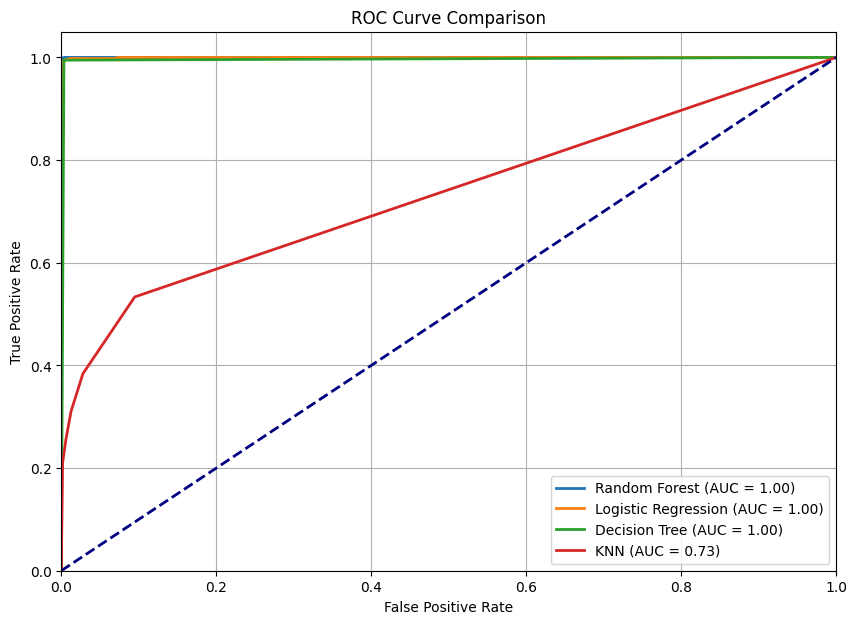

In [ ]:
# ROC Curve for all models
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # For models without predict_proba, use decision_function or skip
        continue
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Overall performance summary

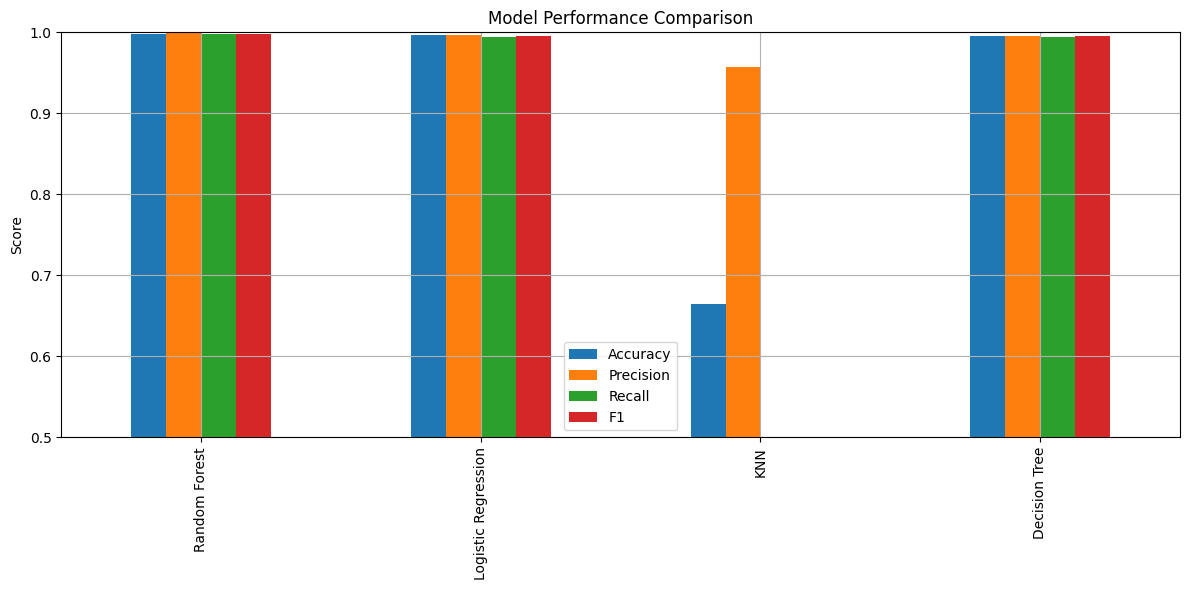

In [ ]:
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1"]).T
results_df.plot(kind='bar', figsize=(12, 6), title="Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix 

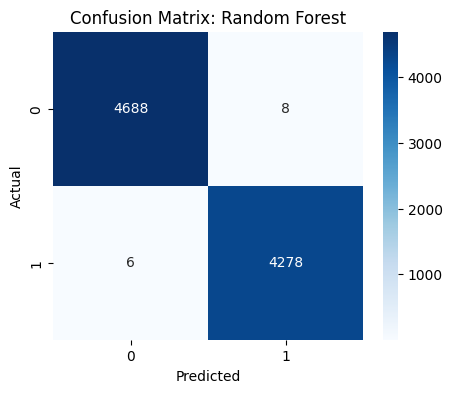

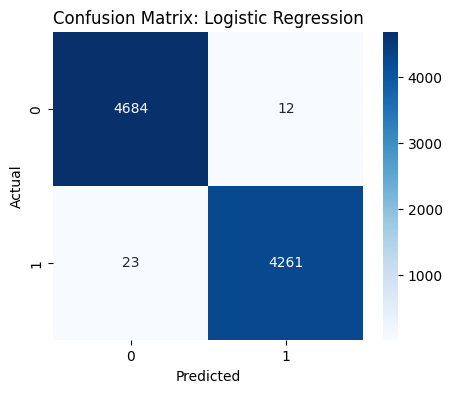

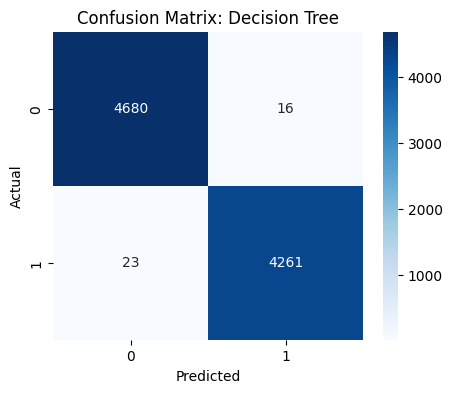

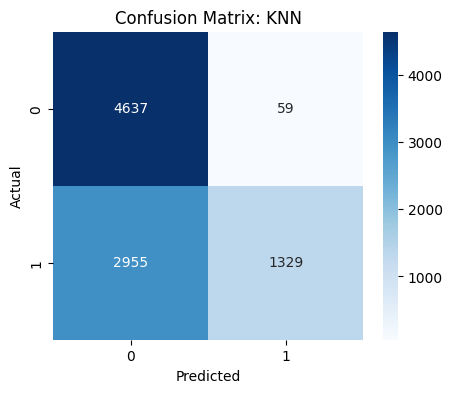

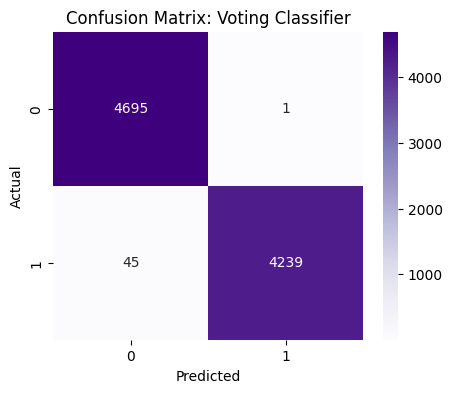

In [ ]:
# Plot confusion matrix for each model
from sklearn.metrics import confusion_matrix
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrix for ensemble voting classifier
if 'voting_model' in locals() or 'voting_model' in globals():
    y_vote = voting_model.predict(X_test_scaled)
    cm_vote = confusion_matrix(y_test, y_vote)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_vote, annot=True, fmt='d', cmap='Purples')
    plt.title("Confusion Matrix: Voting Classifier")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## Check validation 

In [ ]:
"""
Concise validation:
- Print label distribution
- Print sample data preview
- Print classification metrics if predictions exist
"""

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def general_validation(filepath):
    try:
        df = pd.read_csv(filepath)
    except Exception as e:
        print(f"❌ Failed to load file: {e}")
        return None

    # Print only label distribution and sample preview
    label_counts = df['label'].value_counts()
    print(f"Label distribution:\n{label_counts}\n")

    print("Sample data preview:")
    print(df.head(5), "\n")

    # If predicted_label exists, print metrics
    if 'predicted_label' in df.columns:
        y_true = df['label']
        y_pred = df['predicted_label']

        # Validate predicted labels
        if not y_pred.isin([0, 1]).all():
            print("❌ Predicted labels contain values other than 0 and 1.")
            return df

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        print(f"Accuracy : {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall   : {recall:.4f}")
        print(f"F1 Score : {f1:.4f}")

    return df


if __name__ == "__main__":
    filepath = "validation_sample.csv"  # Change if needed
    general_validation(filepath)


Label distribution:
label
0    500
1    500
Name: count, dtype: int64

Sample data preview:
   id                                              title  \
0   1  UN adopts resolution calling for immediate Gaz...   
1   2  EU Parliament passes landmark AI Act to regula...   
2   3  India’s Chandrayaan-4 mission lands near lunar...   
3   4  Bangladesh launches country’s first high-speed...   
4   5  Bangladesh launches country’s first high-speed...   

                                                text  label  
0  UN adopts resolution calling for immediate Gaz...      0  
1  EU Parliament passes landmark AI Act to regula...      0  
2  India’s Chandrayaan-4 mission lands near lunar...      0  
3  Bangladesh launches country’s first high-speed...      0  
4  Bangladesh launches country’s first high-speed...      0   



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# === Load Data ===
df = pd.read_csv("validation_sample.csv")  # must contain 'text' and 'label'

# === Vectorize ===
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text'])
y = df['label']

# === Split Data ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Define Models ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# === Evaluate ===
print("🔍 Model Evaluation Summary:\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"🧠 Model: {name}")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1 Score : {f1:.4f}\n")


🔍 Model Evaluation Summary:

🧠 Model: Logistic Regression
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1 Score : 1.0000

🧠 Model: K-Nearest Neighbors
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1 Score : 1.0000

🧠 Model: Decision Tree
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1 Score : 1.0000

🧠 Model: Random Forest
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1 Score : 1.0000

